# Classically-Boosted Variational Quantum Eigensolver

One of the game-changing applications of quantum computers is expected to be the computation of ground state energies of complicated molecules and materials. Even though there are already some solid proposals on how to tackle these problems when fault-tolerant quantum computation becomes a reality, right now we live in the [`NISQ`](https://en.wikipedia.org/wiki/Noisy_intermediate-scale_quantum_era) era, where we can only access very noisy and limited devices. A large part of the research on quantum algorithms is focusing on what can be done for now with few resources. In particular, most of the proposals of the field rely on variational quantum algorithms that adapt to the limits of the devices and which can be optimized classically. For the specific problem of computing ground state energies this reduces to the very well-known Variational Quantum Eigensolver (VQE) algorithm.

[add picture-drawing VQE vs FT]

Even though VQE is an algorithm specifically targeted to NISQ devices, it still suffers a lot from noise, which usually scales very badly with the number of gates, and also from having to perform many circuit repetitions to compute the ground state energy. As a consequence, many different proposals have explored variations of the original VQE algorithm in order to improve its performance and allow for the simulation of more interesting systems.

In this demo, we will go step-by-step through one of these proposals: the Classically-Boosted Variational Quantum Eigensolver (CB-VQE), which was recently proposed in this [`paper`](https://arxiv.org/abs/2106.04755). This variant of VQE allows us to reduce the number of measurements required to obtain the ground state energy with certain precision by making use of classical states which already carry some information of the ground state of the problem. 

In this demo we will focus on one specific goal which is finding the ground state energy of the $Li_2$ molecule with a certain precision and estimating the quantity of measurements that would be needed in an actual quantum device. The demo will be organized as follows:
- We will first give a short introduction on how to perform normal VQE for the molecule of interest. For more details, we recommend the following [`demo`](https://pennylane.ai/qml/demos/tutorial_vqe.html) to learn how to implement VQE for molecules step-by-step.
- Then, we will focus on the CB-VQE algorithm and implement the details of the algorithm for the specific case in which we rely only on one classical state, that being the Hartree-Fock state.
- Finally, we will briefly discuss the variances and the number of measurements that would be needed for both cases. 

[add picture-drawing]

## NORMAL VQE

If you are not already familiar with the VQE family of algorithms and wish to see how one can apply it the $H_2$ molecule, feel free to work through [VQE overview demo](https://pennylane.ai/qml/demos/tutorial_vqe.html). We will briefly review the main idea behind normal VQE and apply it to the $Li_2$ molecule and use the *6-31G basis* from PennyLane with $M$ active orbitals for $N=6$ electrons. 
The main goal of VQE is to find the ground energy of the Schrödinger equation $H \vert \phi \rangle = E  \vert \phi \rangle$ which corresponds to finding the smallest eigenvalue. An equivalent formulation is to minimize the energy $E = \langle \phi \vert H \vert \phi \rangle$ which acts as a cost function.
The statevector $\vert \phi \rangle$ is prepared by applying a given parameterized ansatz $A(\Theta)$ to the inital state $\vert 0^N \rangle$. The parameters are optimized using classical methods, e.g. we could minimize 
$$
E(\Theta) = \langle 0^{N} \vert A(\Theta)^{\dagger} H A(\Theta) \vert 0^{N} \rangle
$$
with gradient descent. 
For the ansatz $A(\Theta)$ we choose a circuit comprising of *Givens rotations* $G(\Theta)$ (TODO::Is nomenclature correct for higher order excatations?) and $X$-operations. The *Pauli* operations are applied in order to initalize the *Hartree-Fock* state $\vert HF \rangle=\vert 1 \cdots 1 0 \cdots 0 \rangle = X \otimes \cdots \otimes X \otimes I \otimes \cdots \otimes I \vert 0^N\rangle$.
A *Givens rotation* gate physically corresponds to the excitation of a certain number of electrons. 
For now we will focus on single and double excitation gates $G^{(1, 2)}(\Theta)$ which are conveniently implemented in PennyLane with [`SingleExcitation`](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.SingleExcitation.html) and [`DoubleExcitation`](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.DoubleExcitation.html) classes. 
The [`AllSinglesDoubles`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.AllSinglesDoubles.html?highlight=allsinglesdoubles#pennylane.AllSinglesDoubles) class enables us to apply all possible combinations of single and double excitations, which obey the Pauli principle, to the *Hartree-Fock* state. 

15
Step = 0,  Energy = -14.86704134 Ha
Step = 2,  Energy = -14.86874520 Ha
Step = 4,  Energy = -14.87017151 Ha
Step = 6,  Energy = -14.87136246 Ha
Step = 8,  Energy = -14.87235486 Ha
Step = 10,  Energy = -14.87318045 Ha
Step = 12,  Energy = -14.87386636 Ha
Step = 14,  Energy = -14.87443562 Ha
Step = 16,  Energy = -14.87490768 Ha
Step = 18,  Energy = -14.87529890 Ha
Step = 20,  Energy = -14.87562295 Ha
Step = 22,  Energy = -14.87589128 Ha
Step = 24,  Energy = -14.87611340 Ha
Step = 26,  Energy = -14.87629724 Ha
Step = 28,  Energy = -14.87644938 Ha
Step = 30,  Energy = -14.87657527 Ha
Step = 32,  Energy = -14.87667945 Ha
Step = 34,  Energy = -14.87676565 Ha
Step = 36,  Energy = -14.87683698 Ha
Step = 38,  Energy = -14.87689601 Ha
Step = 40,  Energy = -14.87694487 Ha
Step = 42,  Energy = -14.87698530 Ha
Step = 44,  Energy = -14.87701877 Ha
Step = 46,  Energy = -14.87704647 Ha
Step = 48,  Energy = -14.87706941 Ha
Step = 50,  Energy = -14.87708840 Ha
Step = 52,  Energy = -14.87710413 Ha
Ste

Text(0, 0.5, 'energy (Ha)')

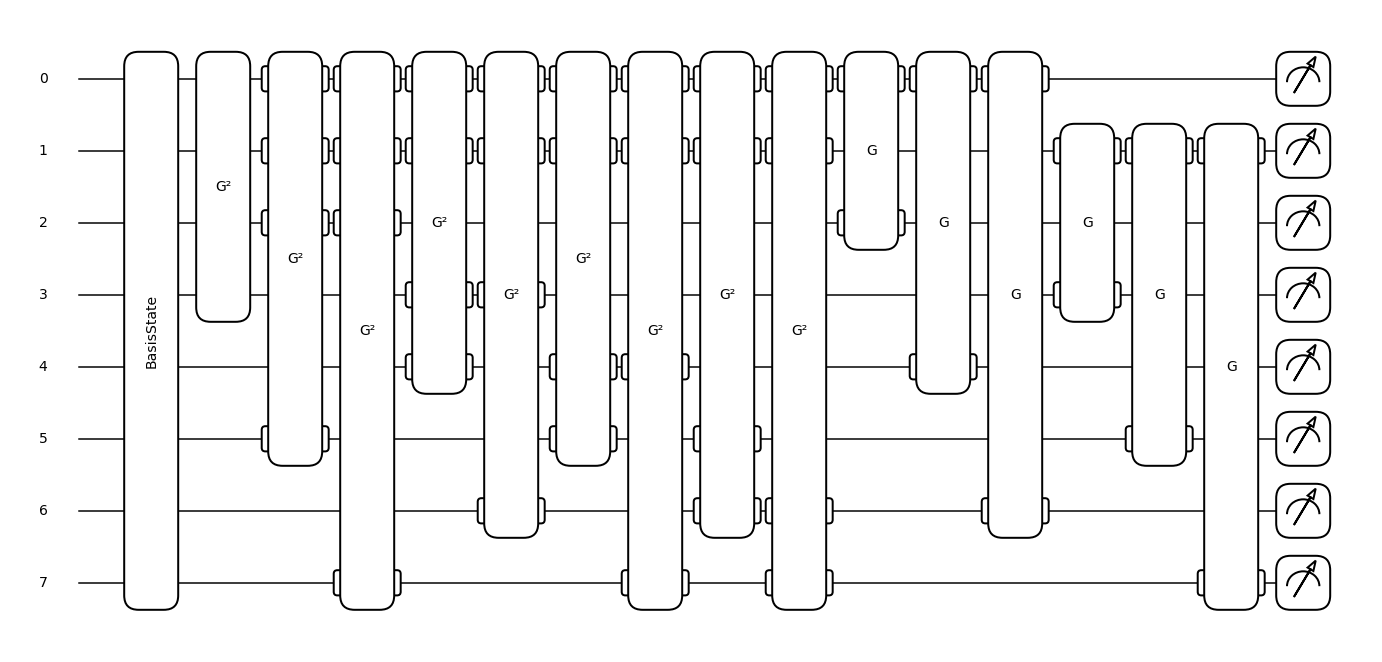

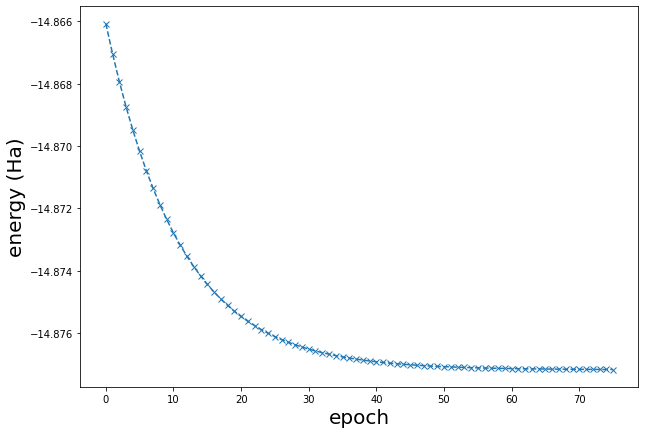

In [2]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# Define the molecular Hamiltonian
symbols, coordinates = qml.qchem.read_structure('./classically_boosted-vqe/li2.xyz')

basis_set = "6-31G"
electrons = 6
orbitals = 6

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Define the HF initial state
hf = qml.qchem.hf_state(electrons, qubits)

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)
print(num_theta)
 
# Define a device
dev = qml.device('default.qubit', wires=qubits)

# Define the cost function and the circuit
def circuit(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

@qml.qnode(dev)
def cost_fn(theta):
    circuit(theta,range(qubits)) # Why define outside?
    return qml.expval(H)

# Draw circuit
qml.drawer.use_style('black_white')
qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

# Gradient descent optimization
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.zeros(num_theta, requires_grad=True)

#  Initial energy
energy = [cost_fn(theta)]
angle = [theta]

# Set the number of iterations and the convergence
max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):

    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(energy ,"x--")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

## CLASSICALLY-BOOSTED VQE

Now we are ready to present the classically-boosted version of VQE. The key of this new method relies on the notion of [`generalized eigenvalue problem`](https://en.wikipedia.org/wiki/Generalized_eigenvalue_problem). The main idea is to restrict the problem of finding the ground state to an eigenvalue problem on a subspace of the total Hilbert space. If this subspace is spanned by the right basis vectors, which will be a combination of both classical and quantum states, our algorithm will become less sensitive to the noise of the quantum device and thus we will be able to reduce the number of measurements needed without sacrificing precision of the final value of the ground state energy.

Let's first define the generalized eigenvalue problem in a subspace spanned by the states $\{\vert \phi_\alpha \rangle\}_\alpha$

$$
\bar{H} \vec{v}=  \lambda \bar{S} \vec{v},
$$

where $\bar{H}$ is the Hamiltonian projected into the states, whose entries are defined as

$$
\bar{H}_{\alpha, \beta} = \langle \phi_\alpha \vert H \vert \phi_\beta \rangle,
$$

and the matrix $\bar{S}$ contains the overlaps between the basis states which is the identity matrix in the case of an orthogonal basis but has to be computed as follows otherwise
$$
\bar{S}_{\alpha, \beta} = \langle \phi_\alpha \vert \phi_\beta \rangle.
$$

Note that $\vec{v}$ and $\lambda$ are the eigenvectors and eigenvalues respectively. In particular, our goal is to find the lowest eigenvalue $\lambda_0$. 

In this demo, following the example from the [`paper`](https://arxiv.org/abs/2106.04755), we consider the simplest case scenario in which the subspace is spanned only by one classical state, $\vert \phi_{HF} \rangle$, and one quantum state, $\vert \phi_{q} \rangle$. In particular, the classical state must be a single [`Slater determinant`](https://en.wikipedia.org/wiki/Slater_determinant), which directly points towards using the Hartree-Fock state for several reasons. On one hand, it is well-known that the Hartree-Fock state is a a good candidate to approximate the ground state in a mean-field limit, but moreover we get it for free when we build the molecular Hamiltonian that we need to run even the normal VQE!

Given all this information, our goal is two build the hamiltonian $\bar{H}$ and the overlap matrix $\bar{S}$, which act on the subspace spanned by $\{\vert \phi_{HF} \rangle, \vert \phi_q \rangle\}$. These will be two-dimensional matrices, and in the following Sections we will show how to compute all their entries step by step.

As before, we start by importing `pennylane`, `qchem` and autodifferentiable `numpy`,

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

and then again defining the molecular hamiltonian in the Hartree-Fock basis for $Li_2$.

In [ ]:
symbols = ["Li", "Li"]
coordinates = np.array([[-0.13150,0.0,0.0], [2.59150,0.0,0.0]])
basis_set = "6-31G"
electrons = 2
orbitals = 4

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

Moreover, which just takes the form and its given by the function

In [ ]:
hf = qml.qchem.hf_state(electrons, qubits)

### Projection onto the classical state

So we first one to compute the entry 
$$
H_{11} = \langle \phi_{HF} \vert H \vert \phi_{HF} \rangle.
$$

Note that this is completely classical! The only thing we need to do is to compute the expectation value of our Hamiltonian on the Hartree-Fock state, which, by definition, is just the Hartree-Fock energy $E_{HF}$.

Using Pennylane, an easy way to compute this expectation value is to construct a circuit in which we implement the Hartree-Fock stae using the function `qml.BasisState` and then output the exectation value. 

In [2]:
dev11 = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev11)
def circuit_H11():
    qml.BasisState(hf, wires=range(qubits))
    return qml.expval(H)

H11 = circuit_H11()

Note running this circuit on a quantum device would definitely not be the most efficient way to compute this expectation value! We just use this functionality in PennyLane because our molecular Hamiltonian is already built in the qubit basis, but we run the circuit classically.

### Projection onto the quantum state

Next, we are interested in computing the entry
$$
H_{22} = \langle \phi_{q} \vert H \vert \phi_{q} \rangle,
$$
where the quantum state $\vert \phi_q \rangle$ is just the output of a normal VQE with a given ansatz, following the steps in the first Section. Then, we see that the entry $H_{22}$ just corresponds to the final energy of the VQE. In particular, note that the quantum state can be written as
$$
\vert \phi_{q} \rangle = U(\{\theta_i^*\}) \vert \phi_{HF} \rangle ,
$$
where $U(\{\theta_i\})$ is the ansatz of the VQE with the optimized parameters $\{\theta_i^*\}$.

### Hamiltonian's crossed terms

Now we are ready to compute the crossed terms:
$$
H_{12} = \langle \phi_{HF} \vert H \vert \phi_{q} \rangle = H_{21}^*.
$$

This part of the algorithm is slightly more complicated than the previous steps, since we will need to use a [`Hadamard test`](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)).

In [15]:
wires = range(qubits + 1)
dev_a = qml.device("default.qubit", wires=wires)

def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

def circuit_HF():
    for wire in range(electrons):
        qml.PauliX(wires=wire)
    for wire in range(electrons, qubits):
        qml.Identity(wires=wire)    
    
Vcl = np.identity(2**qubits)
Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))
W = qml.matrix(circuit_HF)()

@qml.qnode(dev_a)
def hadamard_test(Vq, Vcl, W, component='real'):
    
    if component == 'imag':
        qml.RX(math.pi/2, wires=a_wires)
    
    qml.Hadamard(wires=[0])
    qml.QubitUnitary(W, wires=wires[1:])
    qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
    qml.Hadamard(wires=[0])
    
    return qml.probs(wires=[0])

probs = hadamard_test(Vq, Vcl, W)
y = 2*probs-1

<span style="color:red">(Now I compute the Hamiltonian and S crossed entries (eq. 11 and 12 of the paper). But I am not entirely sure I am doing eq. 11 correctly, actually here I think I am missing something. What are the computational basis states?? It seems to me that i0 is the HF state, and also we only have two y_i, but then what is i1?? It cannot be the quantum state or we are back to the same. Let me know if you undersand this part... )</span>.

In [16]:
H12 = y[0]*H11 + y[1]
H21 = np.conjugate(H12)

S = np.array([[1, y[0]],[y[0], 1]])
H = np.array([[H11, H12],[H21, H22]])

In [5]:
### S-matrix

### Diagonalization of the projected Hamiltonian

Finally, we solve the generalized eigenvalue problem.

In [17]:
from scipy import linalg
evals = linalg.eigvals(H, S)
print('GS energy: ', evals[1])

GS energy:  (-14.76969756216756+0j)


## DISCUSSION ON THE NUMBER OF MEASUREMENTS GIVEN A FIXED OVERLAP AND PRECISION

Now, the goal of the paper is actually estimating the number of measurements needed to obtain a fixed variance in the energies for both VQE and CB VQE.

For doing this, we need to expand the variance of the eigenvalues and obtain an expression in terms of the overlaps. Then, if we fix a precision of $1 mHa$, what is the number of measurements needed?

The ration between them will be the speed up that we obtain.

linalg.eigvals(H, S)

<span style="color:red">(This part is totally missing. Mmhhh I was thinking we could compute something using the measurement implemented in pennylane qml.var(), which directly gives you the variances. I will try to check next week!)</span>.